# Pysindy with DEC data

In [1]:
import dctkit as dt
from dctkit import config
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from dctkit.mesh import util
from dctkit.mesh.simplex import SimplicialComplex
from dctkit.dec import cochain as C
from dctkit.dec.vector import flat_PDP as flat
from matplotlib import cm
import pysindy as ps
from alpine.data.util import load_dataset
from alpine.data.burgers.burgers_dataset import data_path
from dctkit.physics import burgers as b
import math
from sklearn.model_selection import train_test_split
#import gmsh

#gmsh.initialize()

In [2]:
config()

In [3]:
# SPACE PARAMS
# spatial resolution
dx = 2**4/2**9
L = 2**4 + dx
dx_norm = dx/L
L_norm = 1
#  Number of spatial grid points
num_x_points = int(math.ceil(L / dx))
num_x_points_norm = num_x_points

# vector containing spatial points
#x = np.linspace(0, L, num_x_points)
x = np.linspace(-L/2, L/2, num_x_points)
x_circ = (x[:-1] + x[1:])/2

# initial velocity
#u_0 = 2 * np.exp(-2 * (x_circ - 0.5 * L)**2)
u_0 = 1* np.exp(-1 * (x_circ + 0.5 * L/4)**2)
umax = np.max(u_0)

# TIME PARAMS
T = 10
T_norm = T*umax/L
# temporal resolution
dt = 10/2**12
dt_norm = dt*umax/L
# number of temporal grid points
num_t_points_norm = int(math.ceil(T_norm / dt_norm))
num_t_points = num_t_points_norm


t = np.linspace(0, T, num_t_points)
t_norm = np.linspace(0, T_norm, num_t_points_norm)

# Viscosity
#epsilon = 0.005*(L*umax)
epsilon = 0.1
epsilon_norm = epsilon/(L*umax)
print(epsilon_norm)

nodes_BC = {'left': np.zeros(num_t_points_norm),
            'right': np.zeros(num_t_points_norm)}

0.006239345810644392


In [4]:
# generate mesh
# since the mesh points are a lot (> 1000) to not display warnings 
# we put expert mode
#gmsh.option.setNumber("General.ExpertMode", 1)
mesh, _ = util.generate_line_mesh(num_x_points, L, x_min=-L/2)
S = util.build_complex_from_mesh(mesh)
S.get_hodge_star()
S.get_flat_PDP_weights()
# get circ
circ = S.circ[1][:,0]

In [5]:
# construct full u (only for plotting and u_dot)
prb = b.Burgers(S, T, dt, u_0, nodes_BC, epsilon)
prb.run("parabolic")

In [6]:
u = prb.u
u_dot_true = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

In [45]:
## define skip_dx and skip_dt
skip_dx = 2**4
skip_dt = 2**8

# define sub-sampled mesh and time interval
t_sample = t[::skip_dt]
circ_sample = circ[::skip_dx]

u_sample = u[::skip_dx, ::skip_dt]
u_dot_sample = u_dot_true[::skip_dx, ::skip_dt]
print(u_sample.shape)

(32, 16)


In [78]:
# split data
perc_val = 0.1
perc_test = 0.1

# split the dataset in training and test set
time_train_val, time_test, u_train_val_T, u_test_T = train_test_split(
    np.arange(len(t_sample)), u_sample.T, test_size=perc_test, random_state=42, shuffle=False)

# split X_train in training and validation set

time_train, time_val, u_train_T, u_val_T = train_test_split(
    time_train_val, u_train_val_T, test_size=perc_val, random_state=42, shuffle=False)

In [80]:
# order data accordingly: useful only in the (wrong) case shuffle = True
train_sort_map = np.argsort(time_train)
val_sort_map = np.argsort(time_val)
train_val_sort_map = np.argsort(time_train_val)
test_sort_map = np.argsort(time_test)

time_train = time_train[train_sort_map]
time_val = time_val[val_sort_map]
time_train_val = time_train_val[train_val_sort_map]
time_test = time_test[test_sort_map]

u_train_T = u_train_T[train_sort_map,:]
u_val_T = u_val_T[val_sort_map,:]
u_train_val_T = u_train_val_T[train_val_sort_map,:]
u_test_T = u_test_T[test_sort_map,:]

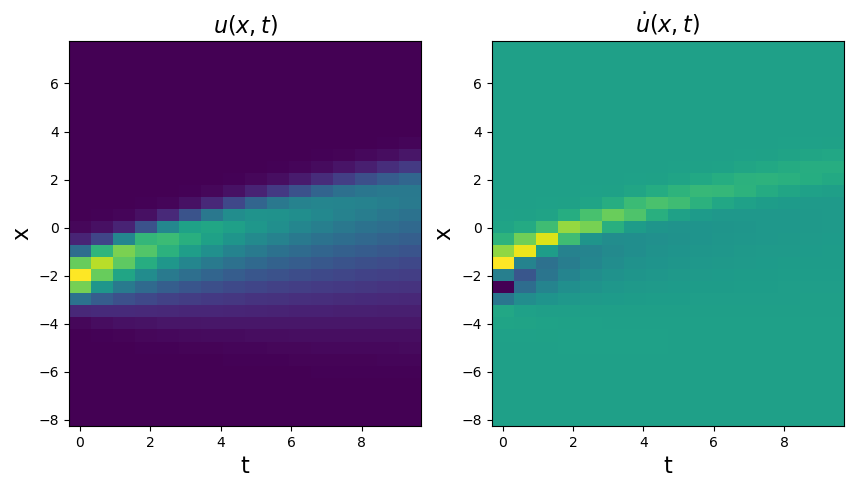

In [81]:
# PLOT FULL DATA
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t_sample, circ_sample, u_sample)
ax[1].pcolormesh(t_sample,circ_sample,u_dot_sample)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$u(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

## Model Selection

In [82]:
# define u_training
t_training = t_sample[time_train]
u_training = u_train_T.T

# define u_training_dot
u_dot_training_true = u_dot_sample[:, time_train]

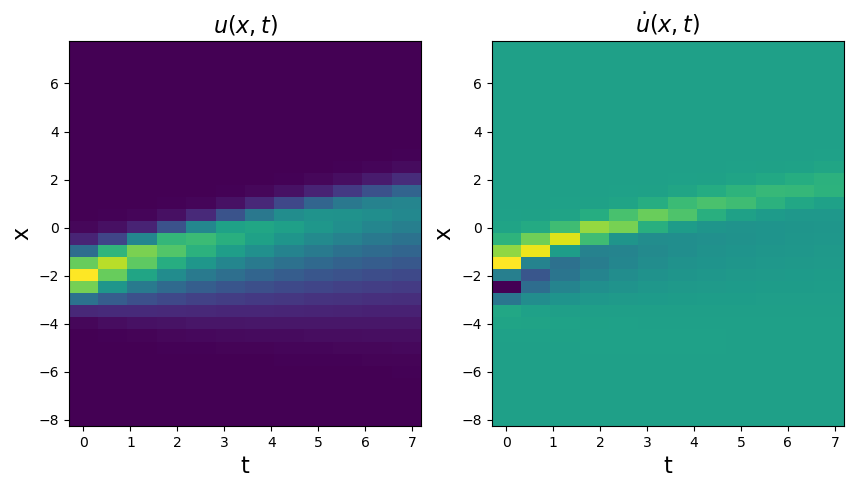

In [83]:
# PRINT TRAINING DATA
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t_training, circ_sample, u_training)
ax[1].pcolormesh(t_training,circ_sample,u_dot_training_true)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$u(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

In [84]:
# reshape u_training and u_dot_training
u_training_reshape = u_training.reshape(len(circ_sample), len(time_train), 1)
u_training_dot_reshape = u_dot_training_true.reshape(u_dot_training_true.shape[0], 
                                                     u_dot_training_true.shape[1], 1)

In [85]:
library_functions = [lambda x: x, lambda x: x*x, lambda x: x*x*x]
library_function_names = [lambda x: x, lambda x: x+x, lambda x: x+x+x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    #derivative_order=5,
    derivative_order=3,
    spatial_grid=circ_sample,
    is_uniform=True,
    include_bias =True,
)


In [86]:
u_val = u_val_T.T
u_val_reshape = u_val.reshape(u_val.shape[0], u_val.shape[1], 1)

u_dot_val_true = u_dot_sample[:, time_val]

In [87]:
# grid search params
threshold_list = [1, 2.5, 5, 7.5, 10]
alpha_list = [1e-1, 1e-2,1e-3, 1e-4, 1e-5]

In [88]:
#GRID SEARCH
def grid_search(threshold_list, alpha_list, l0 =0.001):
    curr_best_error = 1000
    for threshold in threshold_list:
        for alpha in alpha_list:
            optimizer = ps.STLSQ(threshold=threshold, alpha=alpha, normalize_columns=True, verbose=False)
            model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
            model.fit(u_training_reshape, t=t_training)
            u_dot_val = model.predict(u_val_reshape)[:,:,0] + l0*np.count_nonzero(model.coefficients())
            val_err = np.mean(np.linalg.norm(u_dot_val_true - u_dot_val, axis=0)**2)
            if val_err < curr_best_error:
                curr_best_error = val_err
                best_params = (threshold, alpha)
    return curr_best_error, best_params

In [89]:
curr_best_error, best_params = grid_search(threshold_list, alpha_list)
print(curr_best_error)
print(best_params)

0.0007570144504378145
(1, 0.0001)


/home/smanti/mambaforge/envs/dctkit/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (1) and eliminated all coefficients
  warnings.warn(
/home/smanti/mambaforge/envs/dctkit/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (1) and eliminated all coefficients
  warnings.warn(
/home/smanti/mambaforge/envs/dctkit/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (2.5) and eliminated all coefficients
  warnings.warn(
/home/smanti/mambaforge/envs/dctkit/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (2.5) and eliminated all coefficients
  warnings.warn(
/home/smanti/mambaforge/envs/dctkit/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (2.5) and eliminated all coefficients
  warnings.warn(
/home/smanti/mambaforge/

In [71]:
# refined GS
#best_threshold = best_params[0]
#best_alpha = best_params[1]
#threshold_list = [best_threshold-0.5, best_threshold, best_threshold + 0.5]
#alpha_list = [best_alpha/5, best_alpha, best_alpha*5]
#curr_best_error, best_params = grid_search(threshold_list, alpha_list)
#print(curr_best_error)
#print(best_params)

## Model assessment

In [90]:
# define u_train_val
#time_train_val = np.sort(np.concatenate((time_train, time_val)))
t_train_val = t_sample[time_train_val]
#u_train_val = np.vstack((u_train_T, u_val_T)).T
u_train_val = u_train_val_T.T

# define u_training_dot
u_dot_train_val_true = u_dot_sample[:, time_train_val]

In [91]:
# reshape u_train_val and u_dot_train_val
u_train_val_reshape = u_train_val.reshape(len(circ_sample), len(time_train_val), 1)
u_train_val_dot_reshape = u_dot_train_val_true.reshape(u_dot_train_val_true.shape[0], 
                                                     u_dot_train_val_true.shape[1], 1)
print(u_train_val_reshape.shape)


(32, 14, 1)


In [92]:
# fit without u_t
optimizer = ps.STLSQ(threshold=best_params[0], alpha=best_params[1], normalize_columns=True, verbose=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
print('STLSQ model:')
model.fit(u_train_val_reshape, t=t_train_val)
model.print()

STLSQ model:
 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 1.4300e+00 ... 6.1717e-03 ...          8 ... 1.4362e+00
         1 ... 1.1961e+00 ... 6.1312e-03 ...          5 ... 1.2022e+00
         2 ... 1.5026e-01 ... 7.9475e-03 ...          4 ... 1.5820e-01
         3 ... 1.0535e-01 ... 1.0077e-02 ...          4 ... 1.1543e-01
(x0)' = -1.099 x0x0_1 + 1.387 x0x0_11 + -3.178 x0x0x0_11 + 2.023 x0x0x0x0_11


In [23]:
# only in the recovery case
coeffs = model.coefficients()
non_zero_coeffs = coeffs[np.nonzero(model.coefficients())]
print(non_zero_coeffs)
non_zero_coeffs[0] = (non_zero_coeffs[0] - 0.1)*100/0.1
non_zero_coeffs[1] = (non_zero_coeffs[1] + 1)*100
print(np.mean(np.abs(non_zero_coeffs)))

[ 0.10222092 -1.01096274]
1.6585963234580114


In [24]:
# compute new training error
u_dot_train_val = model.predict(u_train_val_reshape)[:,:,0]
print(np.mean(np.linalg.norm(u_dot_train_val_true - u_dot_train_val, axis=0)**2))

8.369127163740785e-05


In [25]:
# defining u_test
u_test = u_test_T.T
u_test_reshape = u_test.reshape(u_test.shape[0], u_test.shape[1], 1)

In [26]:
# define u_dot_test_true and compute u_test
t_test = t[time_test]
u_dot_test_true = u_dot_sample[:, time_test]
u_dot_test = model.predict(u_test_reshape)[:,:,0]

In [27]:
# compute test error
print(np.mean(np.linalg.norm(u_dot_test_true - u_dot_test, axis=0)**2))

4.3795707629492885e-06


## True $\dot{u}$ vs computed $\dot{u}$

In [28]:
# reconstruct u_dot_true_model
u_dot_model = np.zeros_like(u_sample)
u_dot_model[:, time_train_val] = u_dot_train_val
u_dot_model[:, time_test] = u_dot_test

In [29]:
# compute total error
print(np.mean(np.linalg.norm(u_dot_model - u_dot_sample, axis=0)**2))

7.563617701734564e-05


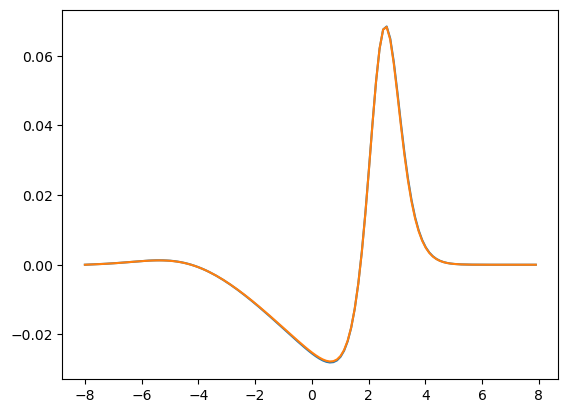

In [30]:
# COMPARISON udot_true VS udot_predict 
# check u_dot profile in the last test time
single_test_time = time_test[-1]
plt.plot(circ_sample, u_dot_model[:,single_test_time])
plt.plot(circ_sample, u_dot_sample[:, single_test_time])
plt.show()

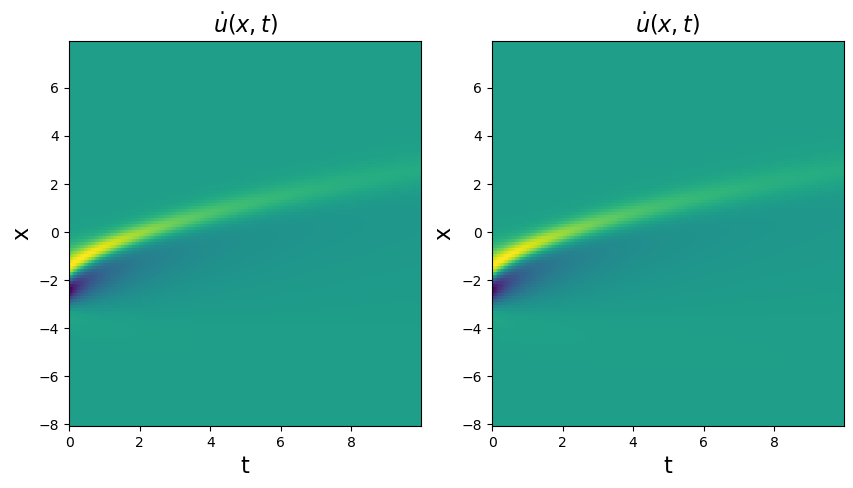

In [31]:
# COMPARISON udot_true VS udot_predict 
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t_sample,circ_sample,u_dot_sample)
ax[1].pcolormesh(t_sample, circ_sample, u_dot_model)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$\dot{u}(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()